Notebook to convert coco-text v2 from coco format to yolo format.

Download the coco-text v2 as per the instructions. You should have the annotations and images.

In [1]:
import json
import cv2
import os
import matplotlib.pyplot as plt
import shutil

In [2]:
input_path = "/home/ernest/gatech/cs7643/coco2014"
output_path = "/home/ernest/gatech/cs7643/yolov7-coco-text/coco-text"

In [5]:
os.makedirs(f"{output_path}/images/train", exist_ok=True)
os.makedirs(f"{output_path}/images/test", exist_ok=True)
os.makedirs(f"{output_path}/images/val", exist_ok=True)
os.makedirs(f"{output_path}/labels/train", exist_ok=True)
os.makedirs(f"{output_path}/labels/test", exist_ok=True)
os.makedirs(f"{output_path}/labels/val", exist_ok=True)

In [6]:
f = open(f'{input_path}/annotations/cocotext.v2.json')
data = json.load(f)
f.close()

In [25]:
cocolist = []
for i in data['anns']:
    cocolist.append(data['anns'][i]['image_id'])
cocolist = set(cocolist)

In [26]:
filelist_train = []
filelist_val = []
for img in data['imgs']:
    if data['imgs'][img]['id'] in cocolist:
        if data['imgs'][img]['set'] == 'train':
            filelist_train.append(data['imgs'][img]['file_name'])
        else:
            filelist_val.append(data['imgs'][img]['file_name'])
            

In [54]:
file_names = []

def load_images_from_folder(folder):
    count = 0
  # for filename in os.listdir(folder):
    for filename in filelist_train:
        source = f'{input_path}/{folder}/{filename}'
        if count < 18000:
            destination = f"{output_path}/images/train/img{count}.jpg"
        else:
            destination = f"{output_path}/images/test/img{count}.jpg"
        try:
            if filename in filelist_train:
                shutil.copy(source, destination)
                count += 1
                # print("File copied successfully.")
        # If source and destination are same
        except shutil.SameFileError:
            print("Source and destination represents the same file.")
    count = 0
    for filename in filelist_val:
        source = f'{input_path}/{folder}/{filename}'
        destination = f"{output_path}/images/val/img{count}.jpg"

        try:
            if filename in filelist_val:
                shutil.copy(source, destination)
                count += 1
                # print("File copied successfully.")
        # If source and destination are same
        except shutil.SameFileError:
            print("Source and destination represents the same file.")

        file_names.append(filename)
        

load_images_from_folder('images')

In [36]:
def get_img_ann(image_id):
    img_ann = []
    isFound = False
    for ann in data['anns']:
        if data['anns'][ann]['image_id'] == image_id:
            img_ann.append(data['anns'][ann])
            isFound = True
    if isFound:
        return img_ann
    else:
        return None

In [37]:

def get_img(filename):
    for img in data['imgs']:
        if data['imgs'][img]['file_name'] == filename:
            return data['imgs'][img]

In [38]:
mapping = {
    'machine printed' : 0,
    'handwritten' : 1,
    'others': 2
}

## Generate labels for Train and Test

In [39]:
count = 0

for filename in filelist_train:
  # Extracting image 
    img = get_img(filename)
    # if img is None:
    #   count += 1
    #   continue

    img_id = img['id']
    img_w = img['width']
    img_h = img['height']

    # Get Annotations for this image
    img_ann = get_img_ann(img_id)
    # print(img_ann)

    if img_ann:
    # Opening file for current image
        if count < 18000:
            file_object = open(f"{output_path}/labels/train/img{count}.txt", "a")
        else:
            file_object = open(f"{output_path}/labels/test/img{count}.txt", "a")
            

        for ann in img_ann:
          # print(ann)
            current_category = mapping[ann['class']] # As yolo format labels start from 0 
            # print(current_category)
            current_bbox = ann['bbox']
            x = current_bbox[0]
            y = current_bbox[1]
            w = current_bbox[2]
            h = current_bbox[3]

            # Finding midpoints
            x_centre = (x + (x+w))/2
            y_centre = (y + (y+h))/2

            # Normalization
            x_centre = x_centre / img_w
            y_centre = y_centre / img_h
            w = w / img_w
            h = h / img_h

            # Limiting upto fix number of decimal places
            x_centre = format(x_centre, '.6f')
            y_centre = format(y_centre, '.6f')
            w = format(w, '.6f')
            h = format(h, '.6f')

            # Writing current object 
            file_object.write(f"{current_category} {x_centre} {y_centre} {w} {h}\n")

        file_object.close()
    count += 1  # This should be outside the if img_ann block.


## Generate labels for Val

In [40]:
count = 0

for filename in filelist_val:
  # Extracting image 
    img = get_img(filename)
    # if img is None:
    #   count += 1
    #   continue

    img_id = img['id']
    img_w = img['width']
    img_h = img['height']

    # Get Annotations for this image
    img_ann = get_img_ann(img_id)
    # print(img_ann)

    if img_ann:
    # Opening file for current image
        file_object = open(f"{output_path}/labels/val/img{count}.txt", "a")

        for ann in img_ann:
          # print(ann)
            current_category = mapping[ann['class']] # As yolo format labels start from 0 
            # print(current_category)
            current_bbox = ann['bbox']
            x = current_bbox[0]
            y = current_bbox[1]
            w = current_bbox[2]
            h = current_bbox[3]

            # Finding midpoints
            x_centre = (x + (x+w))/2
            y_centre = (y + (y+h))/2

            # Normalization
            x_centre = x_centre / img_w
            y_centre = y_centre / img_h
            w = w / img_w
            h = h / img_h

            # Limiting upto fix number of decimal places
            x_centre = format(x_centre, '.6f')
            y_centre = format(y_centre, '.6f')
            w = format(w, '.6f')
            h = format(h, '.6f')

            # Writing current object 
            file_object.write(f"{current_category} {x_centre} {y_centre} {w} {h}\n")

        file_object.close()
    count += 1  # This should be outside the if img_ann block.


## Visualization to check the transformation

In [48]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from PIL import Image, ImageDraw
from numpy import loadtxt

def generate_plots(image, label):

    plotted_image = ImageDraw.Draw(image)
    w, h = image.size
    try:
        for line in label:
            x0 = (line[1] - line[3] / 2) * w
            x1 = (line[1] + line[3] / 2) * w
            y0 = (line[2] + line[4] / 2) * h
            y1 = (line[2] - line[4] / 2) * h

            plotted_image.rectangle(((x0,y0), (x1,y1)))
    except:
        x0 = (label[1] - label[3] / 2) * w
        x1 = (label[1] + label[3] / 2) * w
        y0 = (label[2] + label[4] / 2) * h
        y1 = (label[2] - label[4] / 2) * h

        plotted_image.rectangle(((x0,y0), (x1,y1)))

    plt.imshow(np.array(image))
    plt.show()


### Train

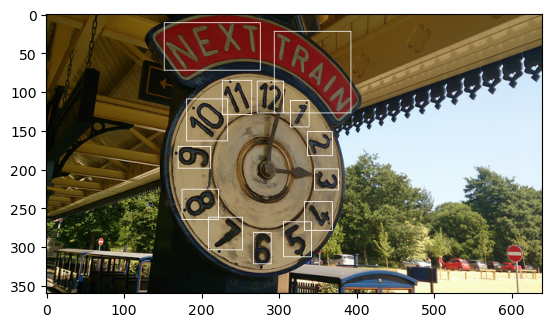

In [53]:
id_ = np.random.randint(0, 18000)
image = Image.open(f'{output_path}/images/train/img{id_}.jpg')
label = loadtxt(f'{output_path}/labels/train/img{id_}.txt', comments="#", delimiter=" ", unpack=False)
generate_plots(image, label)

### Test

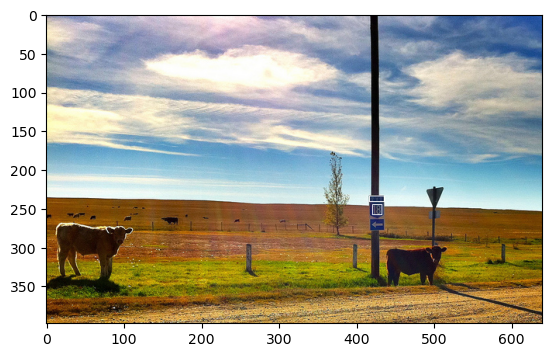

In [50]:
id_ = np.random.randint(18000, 19039)
image = Image.open(f'{output_path}/images/test/img{id_}.jpg')
label = loadtxt(f'{output_path}/labels/test/img{id_}.txt', comments="#", delimiter=" ", unpack=False)
generate_plots(image, label)

### Val

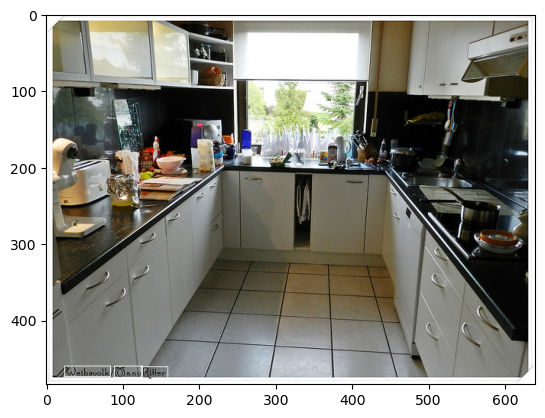

In [52]:
id_ = np.random.randint(0, 4447)
image = Image.open(f'{output_path}/images/val/img{id_}.jpg')
label = loadtxt(f'{output_path}/labels/val/img{id_}.txt', comments="#", delimiter=" ", unpack=False)
generate_plots(image, label)